# Convolution: Nuts & Bolts - III

In this notebook we present the padding technique, then perform convolution with and without padding. At the end, we define a 2D convolution class for using in convnets.


## Tasks
- Convolution: How it Changes the Size of an Image (Feature Map)
- Can we keep the size of the input unchanged?
- Padding: SAME and VALID
- What is the role of padding when stride > 1?
- Python Function for "SAME" Padding
- Convolution Function: Multi-Channel Input, Multiple Filters and Padding
- Edge Detection: Convolution with Padding
- Manually Define a 2D Convolution Class for Convnets

# Convolution: How it Changes the Size of an Image (Feature Map)

In general, the convolution operation reduces the size of an image (feature map). The shape of the output feature map is determined by the shape of the input and the shape of the convolution filter (or kernel). An input $X$ (image or feature map) of height $n_h$ and width $n_w$, when convolved with a filter $K$ of height $f_h$ and width $f_w$ using a stride $s$, reduces the size of its output (feature map) $Z$ by:

- Z (height): $(n_h - f_h)/s + 1$
- Z (width): $(n_w - f_w)/s + 1$

In the example below, the input $X$ is 5 x 5, and filter $K$ is 3 x 3. After convolution using a stride of 1, the size of the output is reduced to 3 x 3.


<img src="http://engineering.unl.edu/images/uploads/Padding_VALID_Stride1.png" width=800, height=400>


Since convolutional filters generally have width and height greater than 1, after applying many successive convolutions, the convnet tends to wind up with outputs that are considerably smaller than the input. For example, say that we have a 240 × 240 pixel image. After performing 10 layers of 5 × 5 convolutions, it will shrink to 200 × 200 pixels. This 30% reduction of the image will lose any interesting information on the boundaries of the original image. 


## Can we keep the size of the input unchanged?

Yes, indeed. The most popular technique to keep the input dimension unchanged is **padding**. 

- But this is possible only when we stride the filter across the image by one pixel, i.e., when stride of length 1 is used.

Let's see how.

When stride of length 1 is used, we can keep the size of the image (or feature map) unchanged by padding the image with layers of zeros around its sides. 


<img src="http://engineering.unl.edu/images/uploads/Padding.png" width=300, height=150>


We denote the number of layers for padding by "p". We add "p" rows from the top and "p" rows from the bottom. Similarly, we add "p" columns from the left, and "p" columns from the right. Thus, the formula for the size of the output becomes. 

- $Z$ (height): $(n_h + 2p - f_h)/s + 1$
- $Z$ (width): $(n_w + 2p - f_w)/s + 1$



Given s = 1, the input dimension is maintained at the output if:

- $n_h + 2p - f_h + 1 = n_h$ and
- $n_w + 2p - f_w + 1 = n_w$

These give:
$p = \frac{f_h - 1}{2}$ or
$\frac{f_w - 1}{2}$

Thus, for the above example, we need to add $p = \frac{3-1}{2}$ = 1 layer of zero padding around each side of the 2D input to keep the output dimension unchanged. This is known as **Same** padding.


<img src="http://engineering.unl.edu/images/uploads/Padding_SAME_Stride1.png" width=800, height=400>


- When no padding is used, we call it **Valid** padding.



## SAME Padding: Benefits

With VALID padding, we tend to lose pixels on the perimeter of the image. In the following figure observe that the pixels at the boundaries (outside the bold squared region on the right figure) are convolved less frequently than the pixels at the middle.

<img src="http://engineering.unl.edu/images/uploads/Padding_LosingPrecision_Boundary.png" width=600, height=300>

Since we typically use small kernels, for any given convolution, we might only lose a few pixels. But this can add up as we apply many successive convolutional layers. 


The SAME padding resolves this problem by adding extra pixels of filler (zero values) around the boundary of the input image. Thus, it increases the effective size of the image. 


CNNs commonly use convolution filters with odd height and width values, such as 1, 3, 5, or 7. Choosing odd filter sizes has the benefit that we can preserve the spatial dimensionality while **padding with the same number** of rows on top and bottom, and the same number of columns on left and right. For example, for a 3 x 3 filter, we need to add $p = \frac{f - 1}{2} = 1$ layer of zero padding on four sides of the input.


Moreover, this practice of using odd filters and padding to precisely preserve dimensionality offers a clerical benefit. For any two-dimensional tensor X, when the filtersʼs size is odd and the number of padding rows and columns on all sides are the same, producing an output with the same height and width as the input.

## Padding Example: VALID & SAME with Stride = 1

Below we show the impact of of both "Valid" and "Same" padding with stride 1. We use tf.nn.conv2d()'s "padding" argument.
- We see that when the "Same" padding is used, the output size doesn't shrink.

In [1]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt

from pylab import imread, gray, imshow

import tensorflow as tf
from tensorflow import keras

In [2]:
X = np.array([[1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1]], dtype=float)
print("Input (X):\n", X)


'''
The tf.nn.conv2d() function requires the input to be a 4D tensor: 
    batch_size x height x width x number_of_channels
    
We need to add a new dimension at the beginning (size of mini-batch), and 
at the end (number of channels).

We create a mini-batch by putting X in an array.
'''

X_array = np.array([X])
print("\nShape of the input array: ", X_array.shape)

# Add an axis at the end for the channel
X_array = expand_dims(X_array, axis=-1)
print("Shape of the input array (with channel): ", X_array.shape)

batch_size, height, width, channels = X_array.shape
print("No. of Channels: ", channels)


# Create a 4D tensor 3 x 3 filter template compatible with the tf.nn.conv2d() function
K = np.zeros(shape=(3, 3, channels, 1), dtype=np.float32)


# Initialize the filter
K[:, :, 0, 0] = np.array([[1, 0, 1], 
                          [0, 1, 0], 
                          [1, 0, 1]])
print("\nFilter:\n", K[:, :, 0, 0])



print("___________________________________\n")



# Perform 2D convolution with the Valid padding
Z_1 = tf.nn.conv2d(X_array, K, strides=1, padding="VALID")

print("Convolution (stride 1 & VALID padding):")
print(Z_1[0, :, :, 0])



# Perform 2D convolution with the Same padding
Z_2 = tf.nn.conv2d(X_array, K, strides=1, padding="SAME")

print("\nConvolution (stride 1 & SAME padding):")
print(Z_2[0, :, :, 0])

Input (X):
 [[1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1.]]

Shape of the input array:  (1, 5, 5)
Shape of the input array (with channel):  (1, 5, 5, 1)
No. of Channels:  1

Filter:
 [[1. 0. 1.]
 [0. 1. 0.]
 [1. 0. 1.]]
___________________________________

Convolution (stride 1 & VALID padding):
tf.Tensor(
[[4. 2. 5.]
 [1. 3. 0.]
 [4. 2. 5.]], shape=(3, 3), dtype=float64)

Convolution (stride 1 & SAME padding):
tf.Tensor(
[[1. 1. 2. 0. 2.]
 [2. 4. 2. 5. 0.]
 [1. 1. 3. 0. 3.]
 [2. 4. 2. 5. 0.]
 [1. 1. 2. 0. 2.]], shape=(5, 5), dtype=float64)


# What is the role of padding when stride > 1 is used?

When performing convolution, by default, we slide one input pixel at a time. However, sometimes, we need to we move the filter more than one pixel at a time (i.e., stride > 1), skipping the intermediate locations:
- To achieve computational efficiency or
- To downsample.

When stride > 1 is used, the "SAME" padding cannot keep the size of the input unchanged. However, it can prevent the reduction being too aggressive.

Consider the following example.

The dimension of the input is 5 x 5 (n x n). We apply a 2 x 2 (f x f) filter with stride = 2. Thus, the side of the output is:

$\frac{n - f}{stride} + 1$

= $\frac{5 - 2}{2} + 1$

= $2.5$


Depending of the type of the padding, the fraction number (for the output sides) will be either rounded down or up.

- VALID: the output size will be 2 x 2 (rounded down).
- SAME: the output size will be 3 x 3 (rounded up).


## VALID Padding: Stride > 1

When padding is set to "VALID", some rows and columns at the bottom and right of the input image may be ignored during convolution. In the following illustration, the rightmost column and the bottom row is never scanned by the filter. As a consequence, the output size becomes 2 x 2. 

<img src="http://engineering.unl.edu/images/uploads/Padding_VALID_Stride2.png" width=800, height=400>


The "VALID" padding ensures that every neuron’s receptive field lies strictly within valid positions inside the input (it does not go out of bounds). Hence the name valid. 

The VALID padding may result into two issues:
- The dimension of the image may reduce significantly as we perform many successive convolutions in deeper networks.
- It may throw away information from the edges.


## SAME Padding: Stride > 1

The above-mentioned **information loss** issue could be resolved by applying the "SAME" padding. It rounds up the output size as needed and adds layers of zero padding to the input. For the above example, a column of zero padding layer is added on the right and a row of zero padding layer is added at the bottom, as follows.


<img src="http://engineering.unl.edu/images/uploads/Padding_SAME_Stride2.png" width=800, height=400>


## Padding Example: VALID & SAME with Stride > 1

In [3]:
X = np.array([[1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1]], dtype=float)

print("Input (X):\n", X)


X_array = np.array([X])
print("\nShape of the input array: ", X_array.shape)

# Add an axis at the end for the channel
X_array = expand_dims(X_array, axis=-1)
print("Shape of the input array (with channel): ", X_array.shape)

batch_size, height, width, channels = X_array.shape
print("No. of Channels: ", channels)


# Create a 4D tensor 3 x 3 filter template compatible with the tf.nn.conv2d() function
K = np.zeros(shape=(2, 2, channels, 1), dtype=np.float32)


# Initialize the filter
K[:, :, 0, 0] = np.array([[1, 0], 
                          [0, 1]]) 
print("\nFilter:\n", K[:, :, 0, 0])



print("___________________________________\n")


# Perform 2D convolution with the VALID padding
Z_3 = tf.nn.conv2d(X_array, K, strides=2, padding="VALID")

print("Convolution (stride 2 & VALID padding):")
print(Z_3[0, :, :, 0])


# Perform 2D convolution with the SAME padding
Z_4 = tf.nn.conv2d(X_array, K, strides=2, padding="SAME")

print("\nConvolution (stride 2 & SAME padding):")
print(Z_4[0, :, :, 0])

Input (X):
 [[1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1.]]

Shape of the input array:  (1, 5, 5)
Shape of the input array (with channel):  (1, 5, 5, 1)
No. of Channels:  1

Filter:
 [[1. 0.]
 [0. 1.]]
___________________________________

Convolution (stride 2 & VALID padding):
tf.Tensor(
[[1. 2.]
 [1. 2.]], shape=(2, 2), dtype=float64)

Convolution (stride 2 & SAME padding):
tf.Tensor(
[[1. 2. 1.]
 [1. 2. 1.]
 [1. 1. 1.]], shape=(3, 3), dtype=float64)


## Python Function for "SAME" Padding

We define a function to add zero padding to the input image or feature map. To do this, we need to compute the size of the padded input. Then create a zero matrix of size equal to the size of the padded input. Finally, copy the original input to the zero-valued matrix. For this, we need to determine locations (indices) of the zero-valued matrix at which the original input to be copied.

The side of the padded input is (two "p" layers are added on both sides) = n + 2p

- n: side of the input
- p: one layer of zero padding


Previously we derived an expression for "p", for the 'SAME' padding (with stride = 1):

$p = \frac{f - 1}{2}$

Now to get an expression for "n", first we use the expression for the side of the feature map:

$f\_map = \frac{n + 2p - f}{s} + 1$

=> $f\_map = \frac{n + 2*\frac{f - 1}{2} - f}{s} + 1$

=> $f\_map = \frac{n -1}{s} + 1$


We get the value of $n$ from this equation:

$\frac{n - 1}{s} = f\_map - 1$

=> $n = (f\_map - 1)*s + 1$

Finally, we compute side of the padded input as follows:

$padded\_input\_side = n + 2p$

=> $padded\_input\_side = (f\_map - 1)*s + 1 + 2*\frac{f - 1}{2}$

=> $padded\_input\_side = (f\_map - 1)*s + 1 + f - 1$

=> $padded\_input\_side = (f\_map - 1)*s + f$


#### We have all the expressions needed to define a function for "SAME" padding.

In [4]:
def same_padding(X, K, stride, padding):
    
    # Get the height & width of the filter (assume that channel information is the first entry)
    f_h, f_w,_, _ = K.shape
    
    # If the filter is 1 x 1, then no padding should be added
    if f_h == 1 and f_w == 1:
        return X
    
    
    # Get the input height, width & number of channels
    n_h, n_w, n_k = X.shape
    
    # Compute the height (z_h) & width (z_w) of the feature map
    z_h = 0
    z_w = 0
    if(padding=='SAME' or padding=='Same' or padding=='same'):
        z_h = (n_h - 1)//stride + 1
        z_w = (n_w - 1)//stride + 1
    else:
        z_h = (n_h - f_h)//stride + 1
        z_w = (n_w - f_w)//stride + 1
        
    
    # Compute the height and width of the padded input
    n_padded_h = max((z_h - 1) * stride + f_h, n_h)
    n_padded_w = max((z_w - 1) * stride + f_w, n_w)
    
    # Create the padded input matrix initialized with zero values
    padded_X = np.zeros((n_padded_h, n_padded_w, n_k), dtype=np.float32)
    
    
    '''
    To copy the original input into the padded input matrix, we need to
         get the start (x, y) coordinates for the original input to be used on the padded input matrix
    - Subtract original input side from the padded input side, and divide by 2 
    '''
    # Get the starting x-coordinate of the original input on the padded input
    start_index_x = (n_padded_h - n_h) // 2
    
    # Get the starting y-coordinate of the original input on the padded input
    start_index_y = (n_padded_w - n_w) // 2
    
    
    # Copy the original input into the padded input matrix
    padded_X[start_index_x:n_h+start_index_x, start_index_y:n_w+start_index_y, :] = X
    
    
    return padded_X

## The "SAME" Padding Function: Example

We test the "same_padding" function using an example below.

In [5]:
X = np.array([[1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1]], dtype=float)

# Add a channel for the color 
X = expand_dims(X, axis=-1)
print("X:\n", X[:, :, 0])


# Create a single dummy filter
K = np.zeros((2, 2, 1, 1))

# Compute the padded input
X_padded = same_padding(X, K, stride=2, padding='SAME')
print("\nPadded X (using SAME padding):\n", X_padded[:, :, 0])

X:
 [[1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0.]
 [1. 1. 1. 0. 1.]]

Padded X (using SAME padding):
 [[1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0.]]


# Convolution Function: Multi-Channel Input, Multiple Filters and Padding

We modify the previously defined "conv_2D_MultiChannelInput_MultipleFilters" function by including the padding argument.

In [6]:
def conv_2D_MultiChannelInput_MultipleChannelFilters_Padding(X, W, s, padding='VALID'):
    
    # If X doesn't have channel information (in case of single-channel), 
    #   then add an axis for the channel at the end
    if(X.ndim == 2): 
        X = expand_dims(X, axis=-1)
        
    # If 'Same' padding is used, then zero padding will be added to the input    
    X = same_padding(X, W, stride=s, padding=padding)
    
    
    # Get the number of filters, height and width 
    f_k = 0 # number of filters
    f_h = 0 # height of each filter
    f_w = 0 # width of each filter
    
    if(W.ndim == 2): # Handles the case if a single multi-channel filter is used 
        f_h, f_w, n_k = W.shape
        f_k = 1
    else:
        f_h, f_w, n_k, f_k = W.shape
        
    # Get the height and width of input as well as the number of channels 
    n_h, n_w, n_k = X.shape
    
    # Create the output (feature map) tensor of dimension: height x width x number of channels
    Z = np.zeros(((n_h - f_h)//s + 1, (n_w - f_w)//s + 1, f_k))    

    
    # Perform convolution
    for i in range(Z.shape[0]): # Get the x-coordinate of the output
        for j in range(Z.shape[1]): # Get the y-coordinate of the output
            # for each filter convolve each input channel with 
            #   the corresponding filter channel to produce a single feature map
            for k_out in range(f_k): 
                for k_in in range(n_k): # For each input channel
                    img_segment = X[i*s: i*s + f_h, j*s: j*s + f_w, k_in] # Get the input region for convolution
                    conv_value = img_segment * W[:, :, k_in, k_out] # Perform convolution for each input channel
                    #conv_total_all_channels += np.sum(conv_value) # Add convolution from each input channel
                    Z[i, j, k_out] += np.sum(conv_value)

    return Z

## Convolution with Padding: Example

We test the above function below.

In [7]:
X = np.array([[1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1], 
              [0, 0, 0, 1, 0], 
              [1, 1, 1, 0, 1]])
print("Input (X):\n", X)

K = np.array([[1, 0, 1], 
              [0, 1, 0], 
              [1, 0, 1]])

K = expand_dims(K, axis=-1)
K = expand_dims(K, axis=-1)
print("\nFilter (K):\n", K.shape)

print("______________________________________________\n")

print("\nConvolution (stride 1 & VALID padding):")
Z_1 = conv_2D_MultiChannelInput_MultipleChannelFilters_Padding(X, K, 1, 'VALID')
print(Z_1[:, :, 0])

print("\nConvolution (stride 1 & SAME padding):")
Z_2 = conv_2D_MultiChannelInput_MultipleChannelFilters_Padding(X, K, 1, 'SAME')
print(Z_2[:, :, 0])


print("\nConvolution (stride 2 & VALID padding):")
Z_3 = conv_2D_MultiChannelInput_MultipleChannelFilters_Padding(X, K, 2, 'VALID')
print(Z_3[:, :, 0])


print("\nConvolution (stride 2 & SAME padding):")
Z_4 = conv_2D_MultiChannelInput_MultipleChannelFilters_Padding(X, K, 2, 'SAME')
print(Z_4[:, :, 0])

Input (X):
 [[1 1 1 0 1]
 [0 0 0 1 0]
 [1 1 1 0 1]
 [0 0 0 1 0]
 [1 1 1 0 1]]

Filter (K):
 (3, 3, 1, 1)
______________________________________________


Convolution (stride 1 & VALID padding):
[[4. 2. 5.]
 [1. 3. 0.]
 [4. 2. 5.]]

Convolution (stride 1 & SAME padding):
[[1. 1. 2. 0. 2.]
 [2. 4. 2. 5. 0.]
 [1. 1. 3. 0. 3.]
 [2. 4. 2. 5. 0.]
 [1. 1. 2. 0. 2.]]

Convolution (stride 2 & VALID padding):
[[4. 5.]
 [4. 5.]]

Convolution (stride 2 & SAME padding):
[[1. 2. 2.]
 [1. 3. 3.]
 [1. 2. 2.]]


## Edge Detection: Convolution with Padding 

Now we test the colvolution function with padding on an edge detection task. We use handcrafted filters in this example.

Shape of Input Image Tensor:  (280, 190, 3)


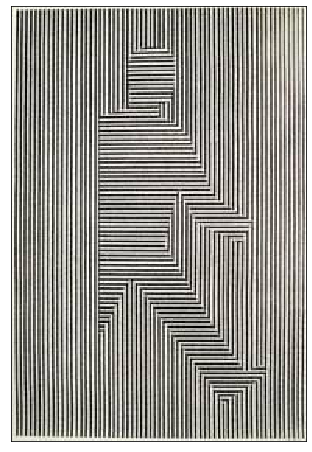


Shape of the filter Tensor (height, width, input channels, output channels):  (3, 3, 3, 2)

Vertical Sobel filters (for all channels):
 [[[-1. -1. -1.]
  [ 0.  0.  0.]
  [ 1.  1.  1.]]

 [[-2. -2. -2.]
  [ 0.  0.  0.]
  [ 2.  2.  2.]]

 [[-1. -1. -1.]
  [ 0.  0.  0.]
  [ 1.  1.  1.]]]

Horizontal Sobel filters (for all channels):
 [[[ 1.  1.  1.]
  [ 2.  2.  2.]
  [ 1.  1.  1.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[-1. -1. -1.]
  [-2. -2. -2.]
  [-1. -1. -1.]]]

Shape of the feature map (number of feature maps, height, width):  (278, 188, 2)

Feature Maps:


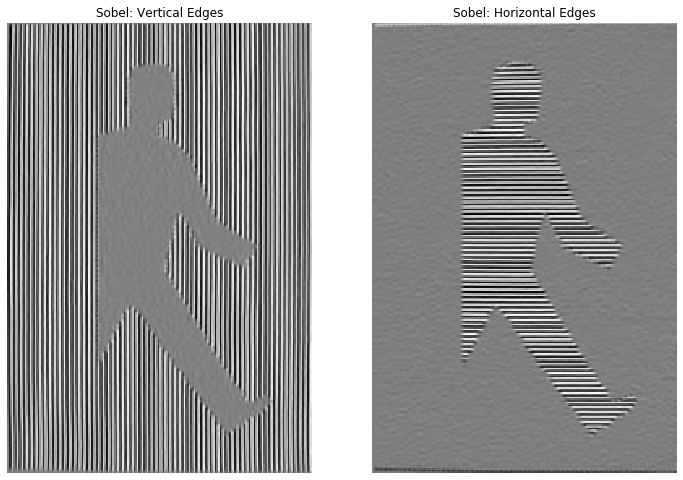

In [8]:
# Read the RGB image 
X = imread("datasets/pics/Stripe.JPG")
#X = imread("datasets/pics/Bench.JPG") 

print("Shape of Input Image Tensor: ", X.shape)

# Display the image
plt.figure(figsize=(10,8))
plt.imshow(X, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.show()


'''
The input image has n_k channels.
Thus, a single filter must have n_k output channels.
The size of a single filter is: height x width x n_k
We create two filters in this example, thus f_k = 2
All filters have: height x width = 3 x 3
The filter tensor is 4D: height x width x n_k x f_k  = 3 x 3 x 3 x 2
- the first filter (with 3 channels) is Sobel vertical filter
- the second filter (with 3 channels) is Sobel horizontal filter
'''

channels_input = 3
channels_output = 2

filters = np.zeros(shape=(3, 3, channels_input, channels_output), dtype=np.float32)

print("\nShape of the filter Tensor (height, width, input channels, output channels): ", filters.shape)

# Create a Sobel filter to detect vertical edges
filters[0, 0, :, 0] = -1
filters[0, 1, :, 0] = 0
filters[0, 2, :, 0] = 1

filters[1, 0, :, 0] = -2
filters[1, 1, :, 0] = 0
filters[1, 2, :, 0] = 2

filters[2, 0, :, 0] = -1
filters[2, 1, :, 0] = 0
filters[2, 2, :, 0] = 1
print("\nVertical Sobel filters (for all channels):\n", filters[:, :, :, 0])

# Create a Sobel filter to detect horizontal edges
filters[0, 0, :, 1] = 1
filters[0, 1, :, 1] = 2
filters[0, 2, :, 1] = 1

filters[2, 0, :, 1] = -1
filters[2, 1, :, 1] = -2
filters[2, 2, :, 1] = -1
print("\nHorizontal Sobel filters (for all channels):\n", filters[:, :, :, 1])


# Perform convolution
Z = conv_2D_MultiChannelInput_MultipleChannelFilters_Padding(X, filters, 1, 'VALID')
print("\nShape of the feature map (number of feature maps, height, width): ", Z.shape)

# Plot the features maps
print("\nFeature Maps:")
plt.figure(figsize=(12,18))

plt.subplot(121)
plt.imshow(Z[:, :, 0], cmap="gray", interpolation="nearest") 
plt.axis("off") 
plt.title("Sobel: Vertical Edges")

plt.subplot(122)
plt.imshow(Z[:, :, 1], cmap="gray", interpolation="nearest") 
plt.axis("off") 
plt.title("Sobel: Horizontal Edges")

plt.show()

# Activation Layer


We have covered the nuts and bolts of the convolution operation. We are ready to define a **spatial convolution or 2D convolution** class for using in the Convolution or Conv layer in a convnet.

One last task we need to present that a Conv layer typically does in convnets. Once the feature maps are computed, those are passed through a nonlinear activation function $f()$ to produce an activated feature map (denoted by $Y$). Each cell of the feature map $Z(i, j, k)$ passes through the activation function to produce an activated output signal.

$Y(i, j, k) = f(Z(i, j, k)$

The most popular choice for $f()$ is Rectified Linear Unit (ReLU) or its variants such as Leaky ReLU, ELU. Following figure illustrates how the ReLU activation function computes the output values from the feature map.

<img src="http://engineering.unl.edu/images/uploads/CNN_Training_Activation.png" width=700, height=400>

The activations are done **in-place** so there is no need to create a separate output feature map volume. Since there is no learning involved, activation layers are usually removed from network architecture diagrams.


# Manually Define a Spatial (2D) Convolution Class for Creating Conv Layers in Convnets


Unlike the previous convolution functions, we don't define this class to take handcrafted filters. In convnets the filter parameters (weights) are learnable. Thus, we initialize the filter weights with small random values (with small variance). 

The randomly-initialized filter (kernel) weight tensor is denoted by $W$ of dimension:
- number of filters $f_k$ x height $f_h$ x  width $f_w$ 

The Conv_2D class takes the following input:
- Image or feature map (denoted by $X$ of dimension height $n_h$ x width $n_w$ x num_of_channels $n_k$)

It requires following parameters:
- filters = number of filters (kernels)  $f_k$
- kernel_size = height and width of the filter (kernel) $f_h$ x $f_w$
- stride = the stride length 
- padding
- activation (the Conv class only uses the ReLU activation function)

It creates a tensor representing feature maps: height x width x number of channels
- height = $\frac{n_h - f_h}{stride} + 1$
- width = $\frac{n_w - f_w}{stride} + 1$
- number of channels  = number of filters $f_k$


## Pseudocode for Convolution


<img src="http://engineering.unl.edu/images/uploads/CNN_Conv_Pseudocode.png" width=800, height=400>


## ReLU Activation Function

We define the ReLU activation function for the 2D conv class.

In [9]:
# ReLU Function
def relu(X):
    
    # Get the height, width and number of channels of the input
    height, width, channels = X.shape
    
    for i in range(height):
        for j in range(width):
            for c in range(channels):
                if(X[i, j, c] < 0 ): # replace negative values with 0
                    X[i, j, c] = 0
    return X

## Test the ReLU Activation Function

In [10]:
# Create a tensor to store two feature maps (with zero values) of dimension 3 x 3
f_maps = np.zeros(shape=(3, 3, 2), dtype=np.float32)

print("Shape of the feature map tensor: ", f_maps.shape)

# Create feature map 1
f_maps[0, 0, 0] = -12
f_maps[0, 1, 0] = 8
f_maps[0, 2, 0] = -34

f_maps[1, 0, 0] = -29
f_maps[1, 1, 0] = -78
f_maps[1, 2, 0] = -67

f_maps[2, 0, 0] = -190
f_maps[2, 1, 0] = -45
f_maps[2, 2, 0] = -1
print("\nFeature Map 1:\n", f_maps[:, :,0])

# Create feature map 2
f_maps[0, 0, 1] = -78
f_maps[0, 1, 1] = -67
f_maps[0, 2, 1] = -23

f_maps[1, 0, 1] = -78
f_maps[1, 1, 1] = 78
f_maps[1, 2, 1] = -23

f_maps[2, 0, 1] = -14
f_maps[2, 1, 1] = -29
f_maps[2, 2, 1] = -155
print("\nFeature Map 2:\n", f_maps[:, :,1])

# Apply ReLU activation to both feature maps
f_maps = relu(f_maps)
print("\nActivated Feature Map 1:\n", f_maps[:, :,0])
print("\nActivated Feature Map 2:\n", f_maps[:, :,1])

Shape of the feature map tensor:  (3, 3, 2)

Feature Map 1:
 [[ -12.    8.  -34.]
 [ -29.  -78.  -67.]
 [-190.  -45.   -1.]]

Feature Map 2:
 [[ -78.  -67.  -23.]
 [ -78.   78.  -23.]
 [ -14.  -29. -155.]]

Activated Feature Map 1:
 [[0. 8. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Activated Feature Map 2:
 [[ 0.  0.  0.]
 [ 0. 78.  0.]
 [ 0.  0.  0.]]


## The Conv 2D Class

In [11]:
class Conv_2D:
    def __init__(self, filters, kernel_size, stride, padding='VALID', activation=None):
        self.f_k = filters # Number of filters
        self.f_h = kernel_size # Height of each filter
        self.f_w = kernel_size # Width of each filter
        self.s = stride
        self.padding = padding
        self.activation = activation

    
    # Method to perform forward propagation through the conv layer
    def forward(self, X):
    
        # If X doesn't have channel information (in case of single-channel), 
        #    add an axix for the channel at the end
        if(X.ndim == 2): 
            X = expand_dims(X, axis=-1)

        # Get the height and width of input as well as the number of channels 
        n_h, n_w, n_k = X.shape
        
        '''
        Create the filter weight matrix of dimension (f_k, f_h, f_w)  
        - Initialize weight values sampling from the “standard normal” distribution (0 mean & unit variance)
        - To reduce the variance of the initial weight values, divide by (f_h * f_w)
        '''
        self.W = np.random.randn(self.f_h, self.f_w, n_k, self.f_k) / (self.f_h * self.f_w)
            
            
        # If the 'Same' padding is used, then zero padding will be added to the input    
        X = same_padding(X, self.W, stride=self.s, padding=self.padding)

        # Create the output (feature map) tensor of dimension: height x width x number of channels
        Z = np.zeros(((n_h - self.f_h)//self.s + 1, (n_w - self.f_w)//self.s + 1, self.f_k))    

        # Perform convolution
        for i in range(Z.shape[0]): # Get the x-coordinate of the output
            for j in range(Z.shape[1]): # Get the y-coordinate of the output
                # for each filter convolve all input channels with 
                #   the corresponding filter channels to produce a single feature map
                for k_out in range(self.f_k): 
                    for k_in in range(n_k): # For each input channel of the current filter
                        # Get the input region for convolution
                        img_region = X[i*self.s: i*self.s + self.f_h, j*self.s: j*self.s + self.f_w, k_in] 
                        # Perform convolution for each input channel for the current filter
                        conv_value = img_region * self.W[:, :, k_in, k_out] 
                        # Add convolution from each input channel
                        Z[i, j, k_out] += np.sum(conv_value)

        return Z
    
        # Apply the ReLU activation function to the feature map
        if(self.activation=='relu'):
            Z = relu(Z)
        return Z

## Convolution Class: Example

We test the convolution class below by scanning an image with an arbitraty number of randomly initialized filters. The feature maps don't detect any meaningful features.

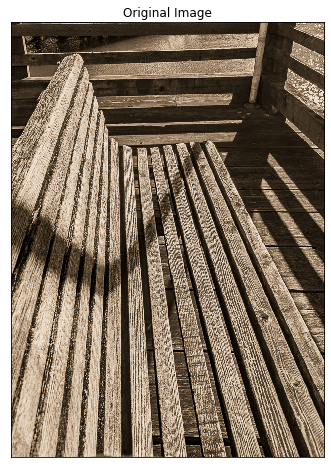


Shape of the feature maps tensor:  (449, 323, 4)

Feature Maps:


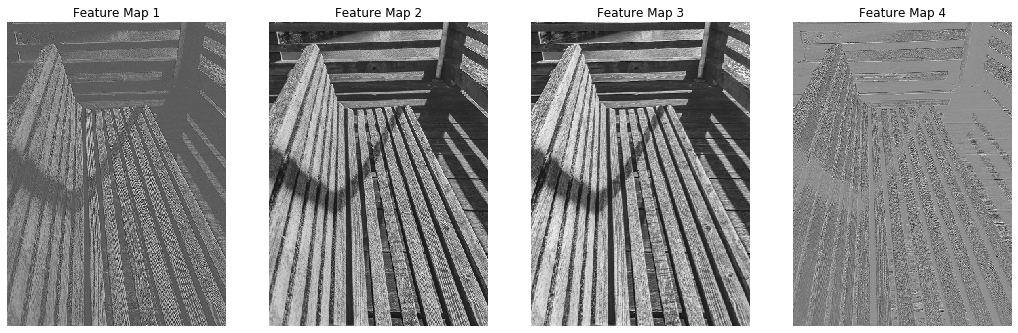

In [12]:
# Load the RGB image and scale it
#X = imread("datasets/pics/Stripe.JPG")
X = imread("datasets/pics/Bench.JPG") /255 

# Display the image
plt.figure(figsize=(10,8))
plt.imshow(X, cmap="gray")
plt.xticks(())
plt.yticks(())
plt.title("Original Image")
plt.show()


# Create a Conv2d layer and perform convolution on the input image
conv = Conv_2D(filters=4, kernel_size=3, stride=2, padding='VALID', activation='relu')
Z = conv.forward(X)
print("\nShape of the feature maps tensor: ", Z.shape)

# Display the features maps
print("\nFeature Maps:")
plt.figure(figsize=(18,8))

plt.subplot(141)
plt.imshow(Z[:, :, 0], cmap="gray", interpolation="nearest") 
plt.axis("off") 
plt.title("Feature Map 1")

plt.subplot(142)
plt.imshow(Z[:, :, 1], cmap="gray", interpolation="nearest") 
plt.axis("off") 
plt.title("Feature Map 2")

plt.subplot(143)
plt.imshow(Z[:, :, 2], cmap="gray", interpolation="nearest") 
plt.axis("off") 
plt.title("Feature Map 3")

plt.subplot(144)
plt.imshow(Z[:, :, 3], cmap="gray", interpolation="nearest") 
plt.axis("off") 
plt.title("Feature Map 4")
plt.show()